In [4]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
matplotlib.rcParams['figure.figsize'] = (12,8)
import pylab as plt
from astrometry.util.fits import *
import numpy as np
from astrometry.util.starutil_numpy import *
from astrometry.util.util import *
from astrometry.libkd.spherematch import *
from scipy.ndimage.morphology import *
from scipy.ndimage.measurements import *
from scipy.interpolate import UnivariateSpline
from collections import Counter

In [69]:
fits_table('/global/cfs/cdirs/cosmo/staging/largegalaxies/v3.2/SGA-ellipse-v3.2.kd.fits', rows=np.arange(10)).about()

tabledata object with 10 rows and 232 columns:
   allmask_g (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   allmask_r (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   allmask_z (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   anymask_g (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   anymask_r (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   anymask_z (<class 'numpy.ndarray'>) shape (10,) dtype >f4
   apflux_blobresid_g (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_blobresid_r (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_blobresid_z (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_g (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_ivar_g (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_ivar_r (<class 'numpy.ndarray'>) shape (10, 8) dtype >f4
   apflux_ivar_w1 (<class 'numpy.ndarray'>) shape (10, 5) dtype >f4
   apflux_ivar_w2 (<class 'numpy.ndarray'>) shape (10, 5) dtype >f4
   apflux_ivar_w3 (<class 'numpy.ndarra

In [70]:
S = fits_table('/global/cfs/cdirs/cosmo/staging/largegalaxies/v3.2/SGA-ellipse-v3.2.kd.fits',
               columns='ra dec preburned type diam in_footprint in_footprint_grz sga_id'.split())
len(S)

3131971

In [71]:
S.about()

tabledata object with 3131971 rows and 8 columns:
   dec (<class 'numpy.ndarray'>) shape (3131971,) dtype >f8
   diam (<class 'numpy.ndarray'>) shape (3131971,) dtype >f4
   in_footprint (<class 'numpy.ndarray'>) shape (3131971,) dtype bool
   in_footprint_grz (<class 'numpy.ndarray'>) shape (3131971,) dtype bool
   preburned (<class 'numpy.ndarray'>) shape (3131971,) dtype bool
   ra (<class 'numpy.ndarray'>) shape (3131971,) dtype >f8
   sga_id (<class 'numpy.ndarray'>) shape (3131971,) dtype >i8
   type (<class 'numpy.ndarray'>) shape (3131971,) dtype <U6


In [72]:
Counter(S.preburned)

Counter({False: 148109, True: 2983862})

In [73]:
S.cut(S.preburned)
len(S)

2983862

In [74]:
Counter(S.get('type'))

Counter({'REX': 1235789,
         'SER': 472119,
         'PSF': 715303,
         'DEV': 152222,
         'EXP': 408429})

In [75]:
Counter(S.sga_id > -1)

Counter({False: 2600294, True: 383568})

In [76]:
S.cut(S.sga_id > -1)
len(S)

383568

In [82]:
zoom = 1
W,H = 800,400
#W,H = 1000,500
#W,H = 2000,1000
ra_center = 275.
wcs = anwcs_create_hammer_aitoff(ra_center, 0., zoom, W, H, False)

In [83]:
ok,S.x,S.y = wcs.radec2pixelxy(S.ra, S.dec)

In [84]:
sgacount = np.zeros(wcs.shape, np.int16)
np.add.at(sgacount, (S.y.astype(int), S.x.astype(int)), 1)

In [85]:
x,y = W//2, H//2
ok,rr,dd = wcs.pixelxy2radec([x, x+1, x], [y, y, y+1])
cosdec = np.cos(np.deg2rad(dd[0]))
dr1 = (rr[1]-rr[0])*cosdec
dd1 = dd[1]-dd[0]
dr2 = (rr[2]-rr[0])*cosdec
dd2 = dd[2]-dd[0]
pixelarea = np.hypot(dr1,dd1) * np.hypot(dr2,dd2)

In [86]:
import matplotlib.cm as cm

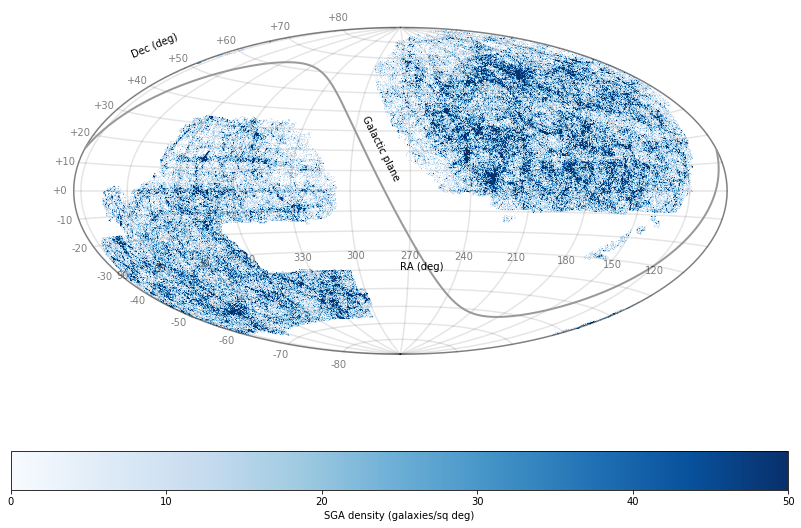

In [89]:
plt.figure(figsize=(12,8))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

# Make zero values truly white (cmap.Blue(0) = 0.97,0.98,1.0)
cmap = cm.Blues
cmap.set_bad(color='white')
density = (sgacount/pixelarea)
density[sgacount==0] = np.nan

plt.imshow(density, vmin=0, vmax=50, cmap='Blues', origin='lower', interpolation='nearest');

c = plt.colorbar(orientation='horizontal')
c.set_label('SGA density (galaxies/sq deg)')

dec_lo = -90
ra_labels_dec = -30

dec_gridlines = list(range(max(dec_lo,-80), 90, 10))
dec_gridlines_ras = np.arange(ra_center-180, ra_center+180, 1)
ra_gridlines = range(0, 360, 30)
ra_gridlines_decs = np.arange(dec_lo, 90, 1.)
dec_gridlines_slope = []
for d in dec_gridlines:
    rr = dec_gridlines_ras
    dd = np.zeros_like(rr) + d
    ok,xx,yy = wcs.radec2pixelxy(rr, dd)
    plt.plot(xx, yy, 'k-', alpha=0.1)
    dec_gridlines_slope.append((yy[-2]-yy[-1]) / (xx[-2] - xx[-1]))
for r in ra_gridlines:
    dd = ra_gridlines_decs
    rr = np.zeros_like(dd) + r
    ok,xx,yy = wcs.radec2pixelxy(rr, dd)
    plt.plot(xx, yy, 'k-', alpha=0.1)

ra_gridlines2 = [ra_center-180, ra_center+180]
ra_gridlines2_decs = np.arange(dec_lo, 91, 1.)
for r in ra_gridlines2:
    dd = ra_gridlines2_decs
    rr = np.zeros_like(dd) + r
    ok,xx,yy = wcs.radec2pixelxy(rr, dd)
    plt.plot(xx, yy, 'k-', alpha=0.5)

ra_labels = ra_gridlines
dec_labels = dec_gridlines
dec_labels_ra = ra_center+180

ok,xx,yy = wcs.radec2pixelxy(ra_labels, ra_labels_dec)
for x,y,v in zip(xx, yy, ra_labels):
    plt.text(x, y, '%i'%(v%360), ha='center', va='top', alpha=0.5)
ok,xx,yy = wcs.radec2pixelxy(dec_labels_ra, dec_labels)
for i,(x,y,v,slope) in enumerate(zip(xx, yy, dec_labels, dec_gridlines_slope)):
    dx = -20
    dy = dx * slope
    r = np.hypot(dx,dy)
    dx = dx * 15 / r
    dy = dy * 15 / r
    #print(v, 'dx,dy', dx, dy)
    plt.text(x+dx, y+dy, '%+i'%v, ha='center', va='center', alpha=0.5)
    if v == 50:
        #angle = np.rad2deg(np.arctan2(dy, dx))
        angle = np.rad2deg(np.arctan2(yy[i+1]-yy[i-1], xx[i+1]-xx[i-1]))
        plt.text(x+dx*3, y+dy*3, 'Dec (deg)', ha='center', va='center', rotation=angle)
# Galactic plane
ll = np.linspace(0., 360., 720)
bb = np.zeros_like(ll)
rr,dd = lbtoradec(ll, bb)
ok,xx,yy = wcs.radec2pixelxy(rr, dd)

# Label
ii = np.argmin(np.abs(rr - 285))
angle = 180+np.rad2deg(np.arctan2(yy[ii+1]-yy[ii-1], xx[ii+1]-xx[ii-1]))
plt.text(xx[ii], yy[ii], 'Galactic plane', ha='center', va='bottom', rotation=angle)

# Plot segments that are above min Dec and not discontinuous
d = np.append([0], np.hypot(np.diff(xx), np.diff(yy)))
ok = (d < 100) * (dd > dec_lo)
istart = 0
while istart < len(ok):
    while istart < len(ok) and ok[istart] == False:
        istart += 1
    iend = istart
    while iend < len(ok) and ok[iend] == True:
        iend += 1
    if iend != istart:
        #print('Plotting from', istart, 'to', iend, 'ok', ok[istart:iend])
        plt.plot(xx[istart:iend], yy[istart:iend], '-', color='0.6', lw=2)
    istart = iend

ok,x,y = wcs.radec2pixelxy(ra_center, -40)
plt.text(x, y, 'RA (deg)')

plt.xticks([])
plt.yticks([])
plt.axis('equal');
#ax = [0,W, 0.2*H, H]
#plt.axis(ax)
#plt.axis('equal')
#plt.axis(ax)
plt.gca().set_frame_on(False)

plt.savefig('sga.png')